# カチャカAPIワークショップ

## カチャカAPIを利用するための準備
カチャカAPIを利用するためのクライアントを準備します。
プログラムを作成する際は以下のコードを先頭に書いて利用することとなります。

In [ ]:
import kachaka_api
client = kachaka_api.aio.KachakaApiClient()
await client.update_resolver()
await client.set_auto_homing_enabled(False)

また、ワークショップで利用するコードが依存するライブラリのimportも行っておきます。

In [ ]:
import asyncio
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt
import numpy as np

## カチャカを発話させる

まずはclientの動作確認も兼ねて、カチャカに発話させてみましょう。  
下記のコマンドを実行すると、speakの中に指定された文章を発話します。  
使用しているカチャカが喋っていることを確認するために、XXの部分を利用しているカチャカの番号に変えて実行してみてください。

In [ ]:
await client.speak("こんにちは、カチャカXXです")

## カチャカで家具を運ぶ

つづいてカチャカの基本機能である、家具の移動を行ってみましょう。   
家具を移動させるためには移動先となる目的地と、運ぶ対象となる家具の登録を行う必要があります。

### 目的地の登録

まずは移動先となる目的地を登録します。  
カチャカはアプリから指定した地点を目的地として登録することができます。  
目的地の登録はアプリから行います。
[目的地を追加する](https://kachaka.zendesk.com/hc/ja/articles/6370952671759-%E7%9B%AE%E7%9A%84%E5%9C%B0%E3%82%92%E8%BF%BD%E5%8A%A0%E3%81%99%E3%82%8B)を参考に移動先の目的地を追加してください。  
<img src=attachment:ba45f2c1-bc4b-4d8e-aa69-ad597ad3bc02.png width="25%"><img src=attachment:515383c5-e770-4f1b-91c2-0e79170ff3f8.png width="25%"><img src=attachment:3e9fef33-5967-44bb-8520-6582baece17b.png width="25%">  
マップ上で位置指定して目的地を追加する例。矢印がある側がロボットの正面になります。つまりこの場合はカチャカは目的地で左下の方向を向きます。  

### 目的地への移動

目的地の登録が完了すると、APIから目的地を指定してカチャカを移動させることができます。  
下記の"目的地"を先程登録した名前に書き換えて実行して下さい。
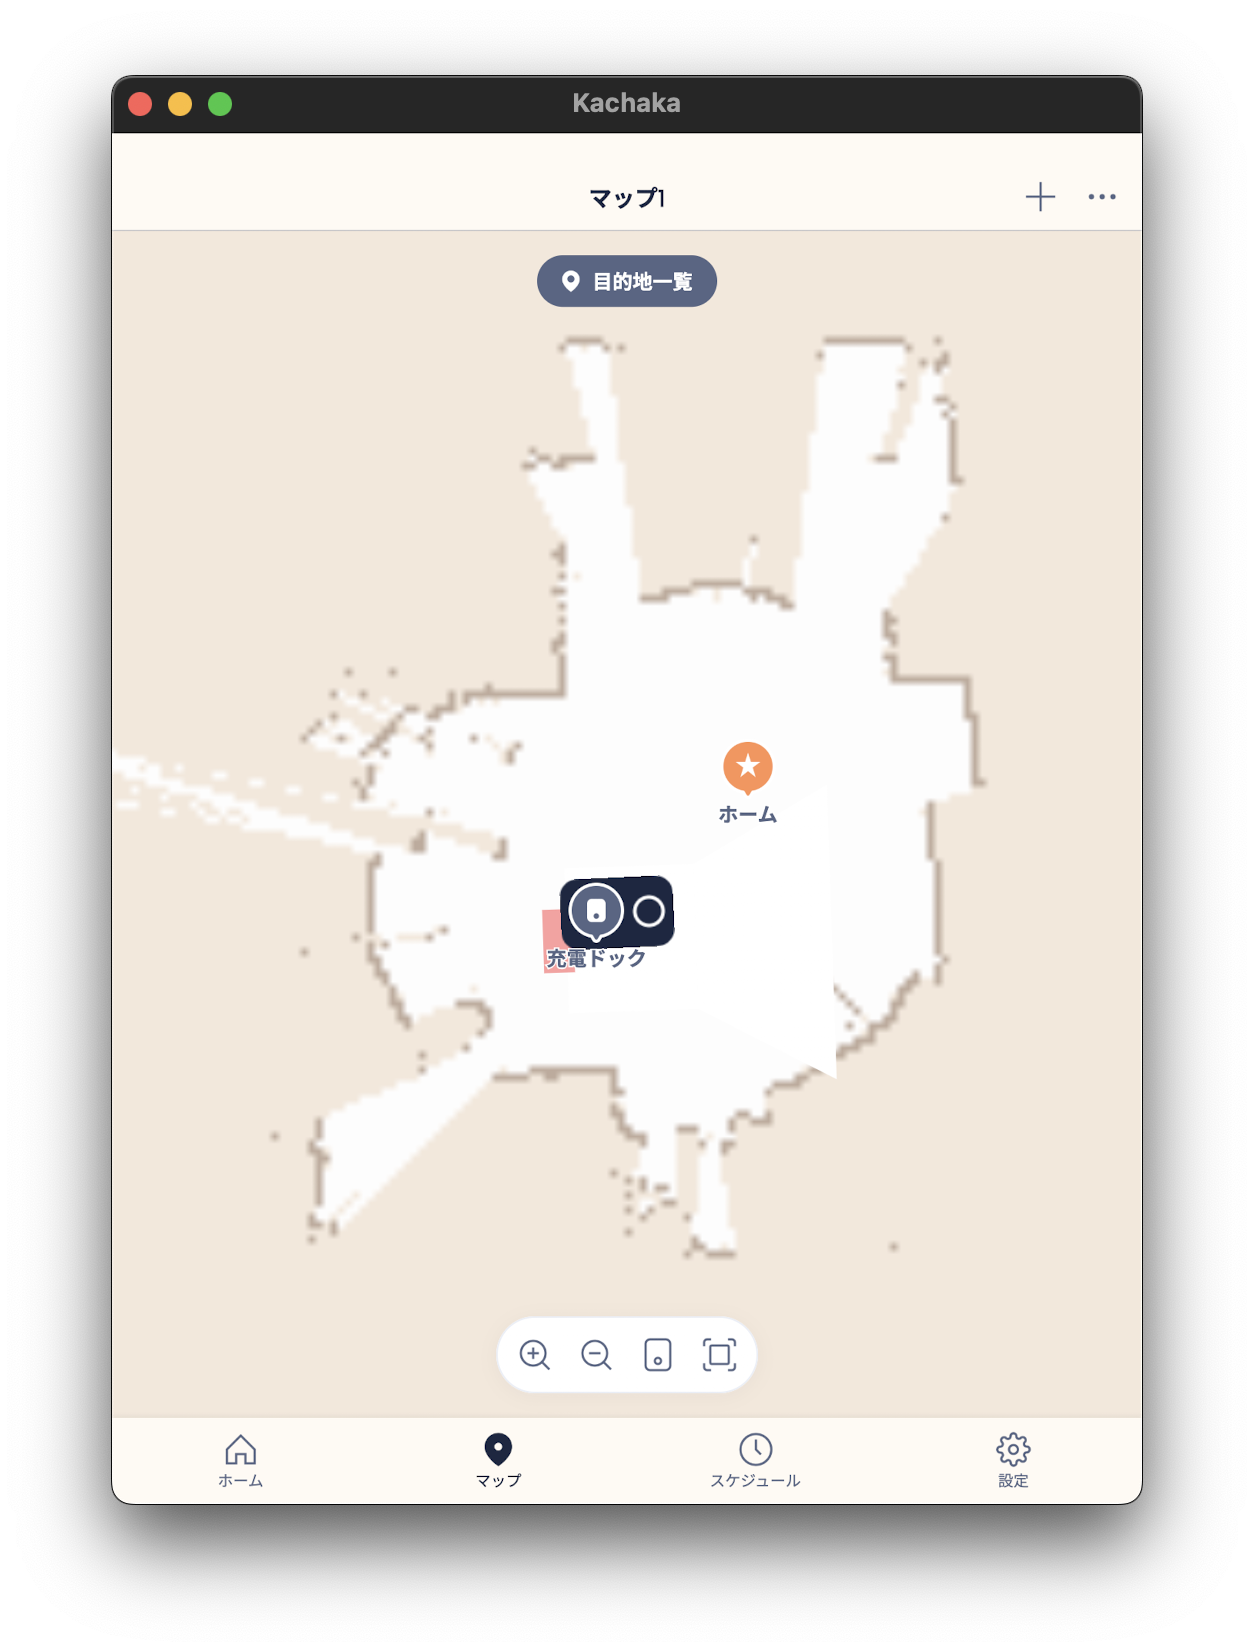
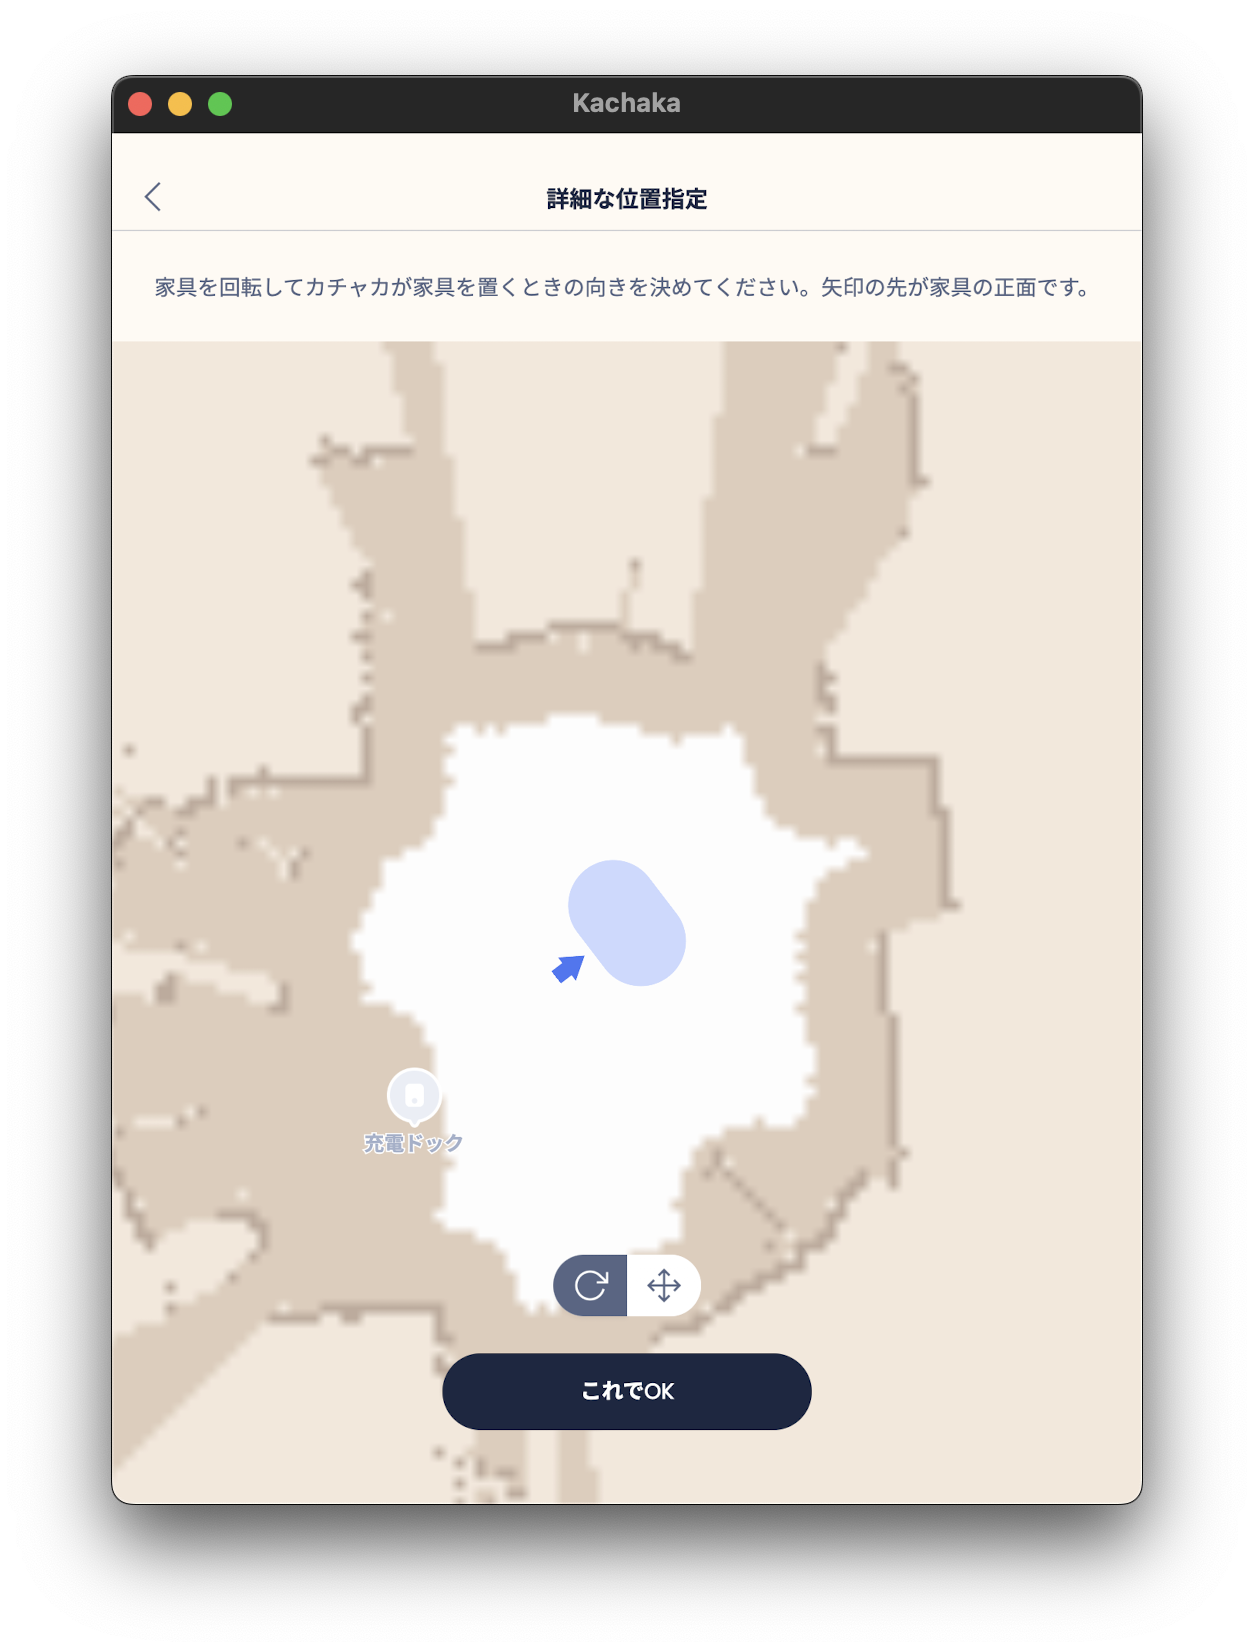
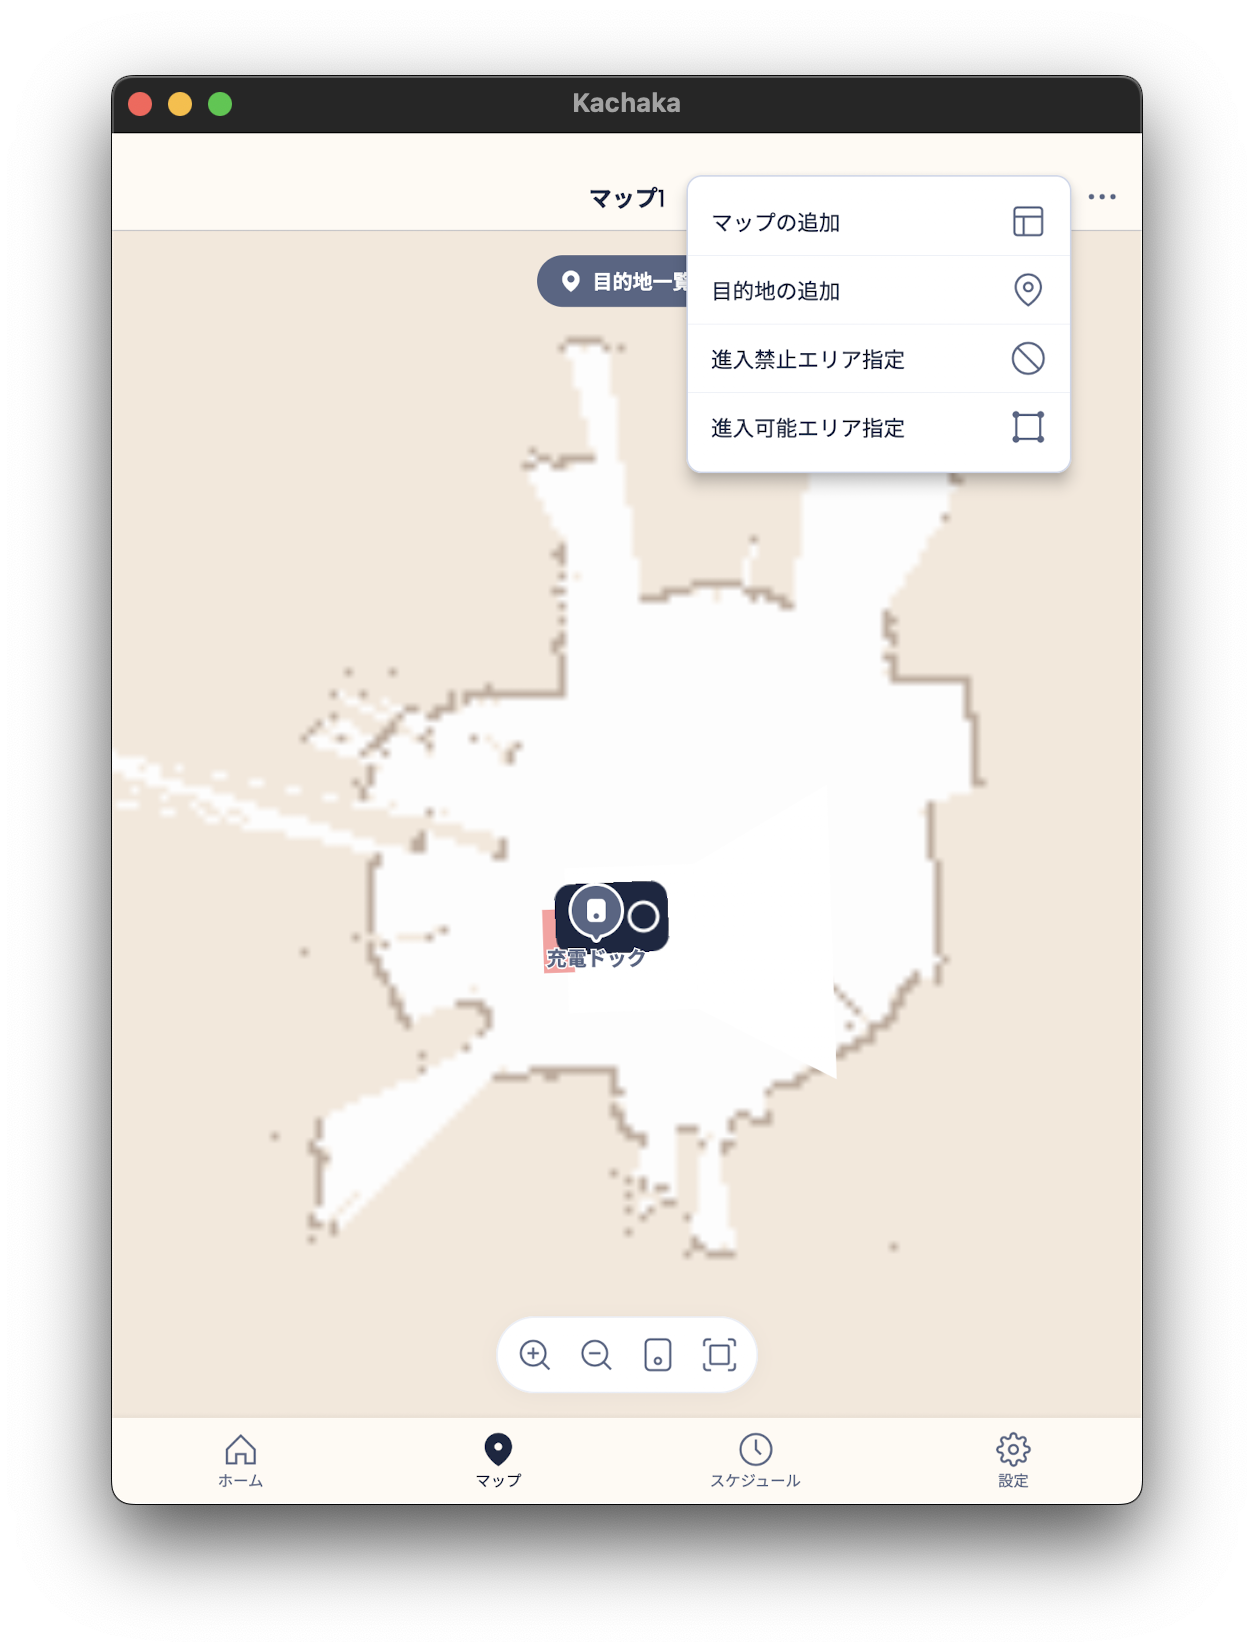

In [ ]:
await client.update_resolver()  # 新しく登録された目的地名を取得
await client.move_to_location("目的地")

### 充電ドックへの移動

下記を実行して充電ドックに戻ります。

In [ ]:
await client.return_home()

### 家具の登録

家具の登録はアプリから行います。
[家具を追加する](https://kachaka.zendesk.com/hc/ja/articles/6370685074575-家具を追加する)を参考に移動先の目的地を追加してください。  
<img src=attachment:630a98f9-e389-43cc-8dee-fce3776d58f5.png width="25%"><img src=attachment:c0a80a76-8fa0-472d-b890-1cdca11feb00.png width="25%">  

### 家具を運ぶ

家具の登録が完了すると、APIから目的地を指定して家具を運ぶことができます。  
下記の"家具", "目的地"を登録したものに書き換えて実行して下さい。
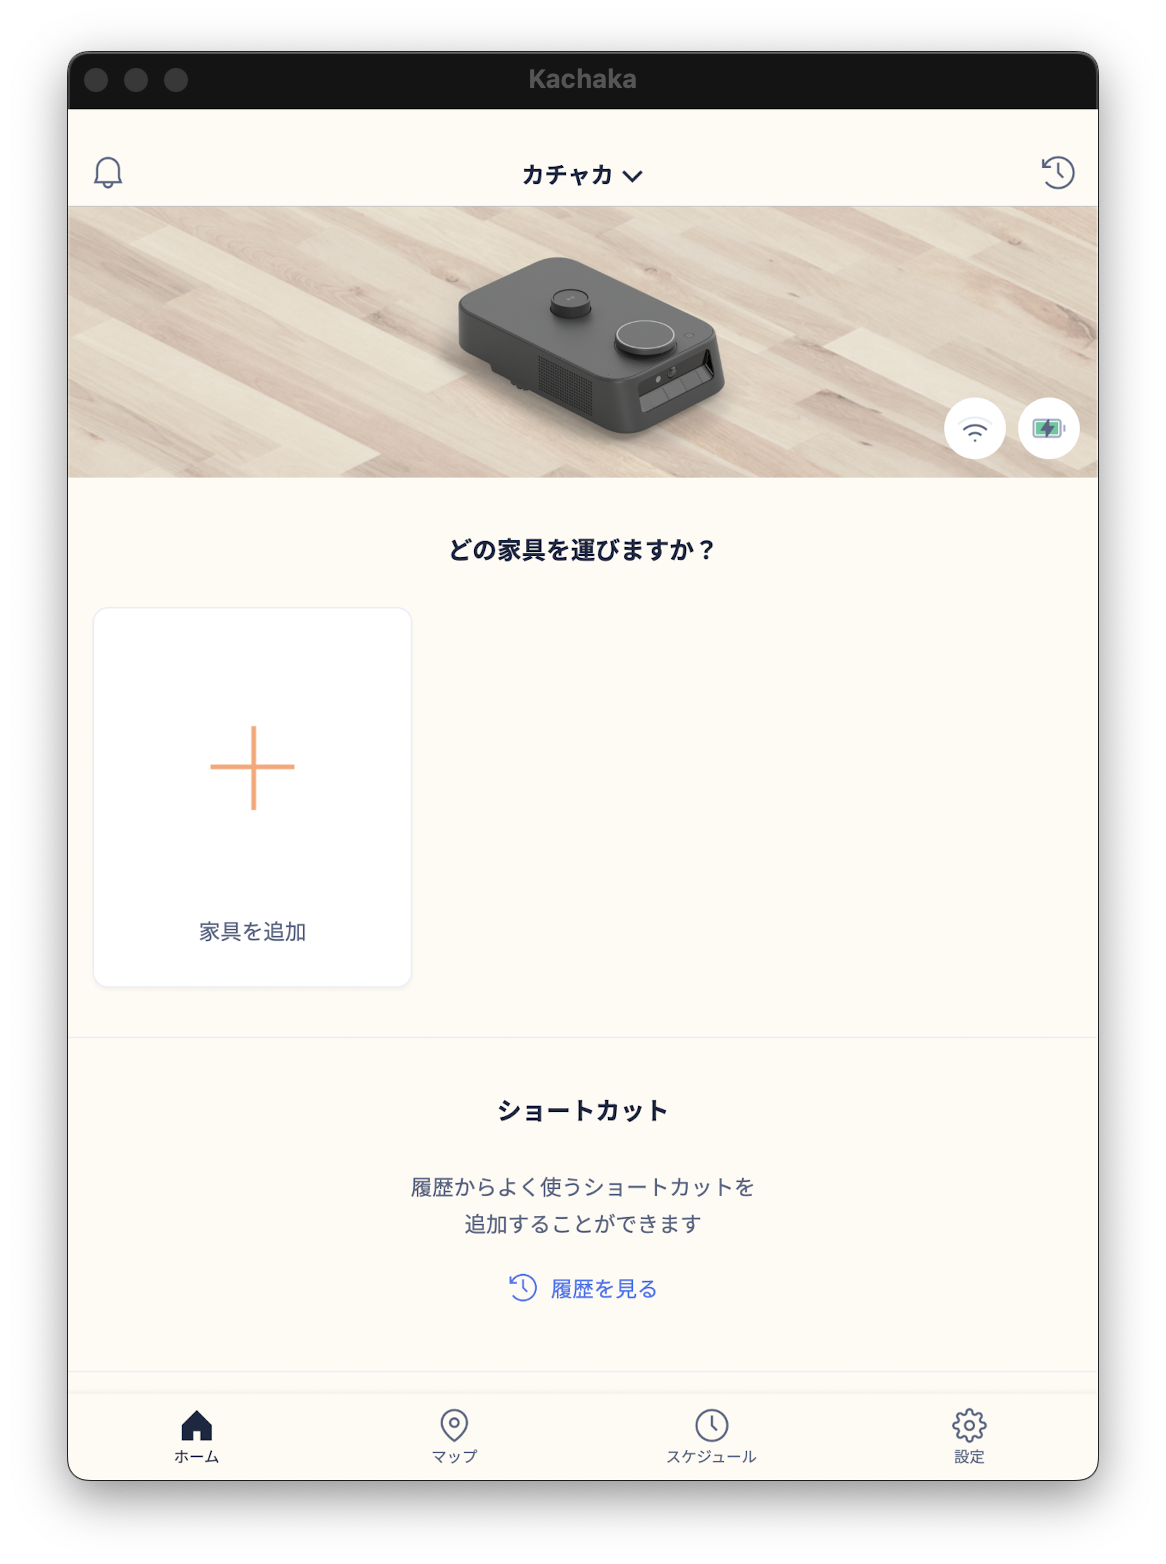
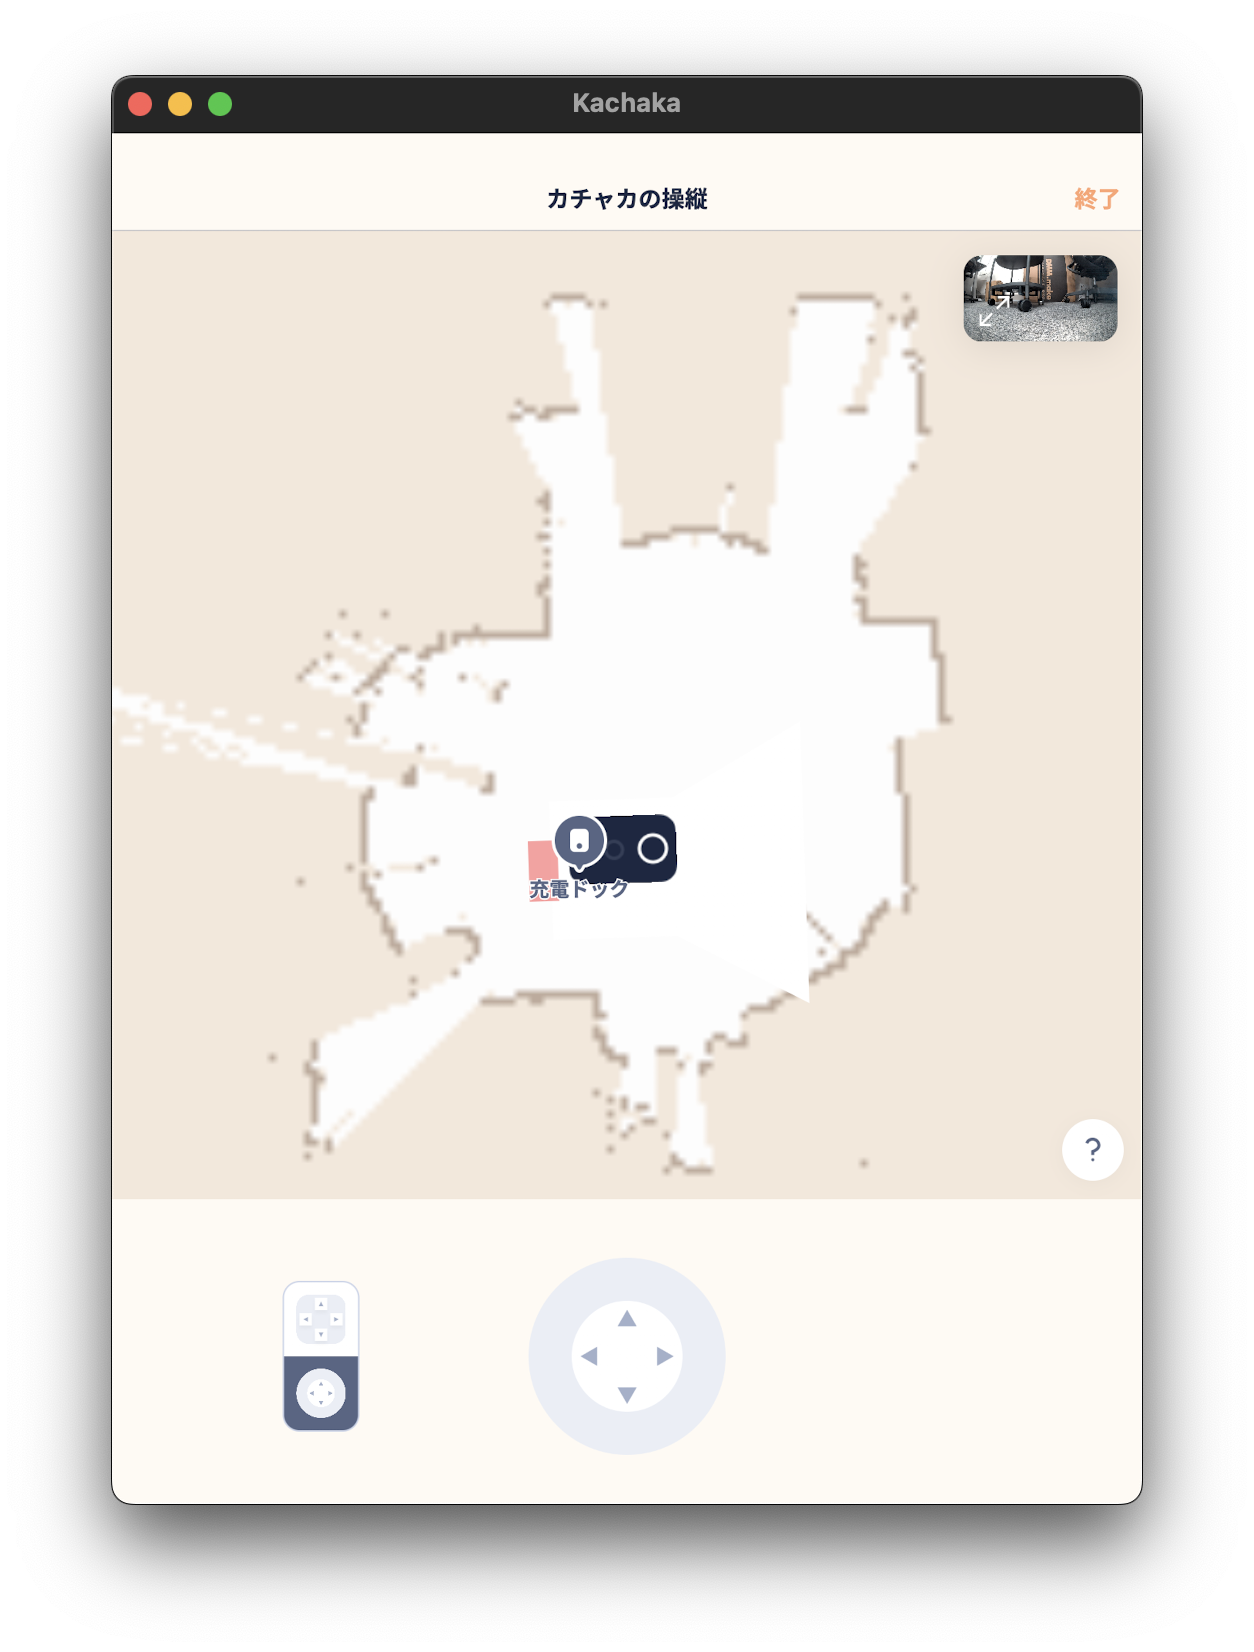

In [ ]:
await client.update_resolver()  # 新しく登録された家具名を取得
await client.move_shelf("家具", "目的地")

### 家具を置く

家具とドッキング中は、move_to_location, return_homeは実行できません。  
家具を置いてから充電器に戻します。

In [ ]:
await client.undock_shelf()
await client.return_home()

### 家具を片付ける

下記のコマンドを実行すると、家具をその家具のホームの位置にまで移動させ、置きます。

In [ ]:
await client.return_shelf("家具")

## 座標を指定してカチャカを移動させる

地図上の座標を指定してカチャカを動かすこともできます。  
カチャカをマップ上30cm前に動かしてみましょう。  
今いる現在地を取得して、そこから30cmの地点を目標値として与えます。

### 現在の座標の取得

まずはカチャカの現在の座標を下記のコマンドで取得します。  
単位はx, y方向がm, thetaがradianです。

In [ ]:
pose = await client.get_robot_pose()
print(pose)

### 座標を指定した移動

取得したposeを基準にして、移動先の値を与えます。

In [ ]:
await client.move_to_pose(pose.x, pose.y + 0.3, pose.theta)

## 速度制御

位置ではなく速度を指定して動かすことも可能です。指定する値の単位は(m/s, rad/s)です。  
下記は 0.628rad/s ≒ 36deg/s を10秒間与えています。

In [ ]:
for i in range(10):
    await client.set_robot_velocity(0.0, 0.628)
    await asyncio.sleep(1)
await client.set_robot_stop()

## カメラ画像

下記の実行でカメラ画像を取得、表示します。

In [ ]:
image = await client.get_front_camera_ros_compressed_image()  # カメラ画像を取得
display(Image(data=image.data, format="jpeg"))  # 取得した画像を表示

### カメラ画像の連続取得

下記のように記述すると、新しいカメラ画像が来るたびに表示を更新することができます。  
実行の停止はJupyterLab上部のバーの ■ ボタンで行ってください。

In [ ]:
try:  # 停止を検出するための記述
    async for image in client.front_camera_ros_compressed_image.stream():  # 画像が更新されるたびに実行
        clear_output(wait=True)  # 前回表示した画像をクリア
        display(Image(data=image.data, format="jpeg"))  # 画像を表示
except asyncio.CancelledError:  # 停止を検出するための記述
    print("-> 停止しました")

### 物体認識結果の取得

下記は物体認識結果を取得するサンプルです。

In [ ]:
from kachaka_api.util.vision import get_bbox_drawn_image, OBJECT_LABEL
stream_i = client.front_camera_ros_compressed_image.stream()  # カメラ画像を取得するstream
stream_d = client.object_detection.stream()  # 物体検出結果を取得するstream
try:  # 停止を検出するための記述
    while True:
        image, (header, objects) = await asyncio.gather(anext(stream_i), anext(stream_d))  # カメラ画像、物体検出結果がくるまで待つ
        img = get_bbox_drawn_image(image, objects)  # 物体検出結果が書かれた画像を作成
        clear_output(wait=True)  # 前回表示した画像をクリア
        display(img)  # 画像を表示
        for object in objects:
            display(f"{OBJECT_LABEL[object.label]}, score={object.score:.2f}")  # 検出された物体のlabelとscoreをprint
except asyncio.CancelledError:  # 停止を検出するための記述
    print("-> 停止しました")

## 各種センサデータ等の取得

#### マップ上の姿勢の取得
- 単位はm, radianです

In [ ]:
await client.get_robot_pose()

#### マップ情報の取得
- マップ画像とマップ座標との対応関係については、[plot_map_lidar.ipynb](./plot_map_lidar.ipynb) を参照

In [ ]:
map = await client.get_png_map()
print(map.name)
print(map.resolution, map.width, map.height)
print(map.origin)
display(Image(data=map.data))

#### LiDARの点群情報の取得
- LiDARは充電ドック上にいる間は停止しており、データが更新されません


In [ ]:
scan = await client.get_ros_laser_scan()

theta = np.linspace(scan.angle_min, scan.angle_max, len(scan.ranges))
dist = np.array(scan.ranges)

# LiDARの点群を表示するサンプル
plt.scatter(dist * np.cos(theta), dist * np.sin(theta))

#### IMU情報の取得

In [ ]:
response = await client.get_ros_imu()
response.linear_acceleration

#### オドメトリの取得

In [ ]:
response = await client.get_ros_odometry()
response.twist.twist

## 参考リンク集

[Qiita投稿記事](https://qiita.com/organizations/pfrobotics/items) : 社員によるカチャカAPIを利用したより実践的な記事が投稿されています。

### demo notebookリンク

TODO